In [2]:
import pandas as pd
import statsmodels.api as sm

macro_econ_data: pd.DataFrame = sm.datasets.macrodata.load_pandas().data
macro_econ_data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [3]:
from typing import Union
import numpy as np
from statsmodels.tsa.stattools import adfuller

def test_stationarity(data: Union[pd.Series, np.ndarray]):
    result = adfuller(data)
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')

In [4]:
test_stationarity(macro_econ_data['realdpi'])
test_stationarity(macro_econ_data['realcons'])

ADF Statistic: 2.986
p-value: 1.000
ADF Statistic: 1.550
p-value: 0.998


In [5]:
test_stationarity(macro_econ_data['realdpi'].diff().iloc[1:])
test_stationarity(macro_econ_data['realcons'].diff().iloc[1:])

ADF Statistic: -8.865
p-value: 0.000
ADF Statistic: -4.204
p-value: 0.001


In [23]:
from typing import Optional
from tqdm.notebook import tqdm
from itertools import product
from statsmodels.tsa.statespace.varmax import VARMAX

pq = tuple[int, int]

def optimize_VARMAX(
    endog: pd.Series,
    order_list: list[pq], # [(p, q), ...]
    exog: Optional[pd.DataFrame] = None,
):
    results: list[tuple[pq, float]] = []
    for order in tqdm(order_list):
        model = VARMAX(endog, exog, order=order).fit(disp=False)
        aic = model.aic
        results.append((order, aic))
    result_df = (pd.DataFrame(results, columns=('(p, q)', 'AIC'))
                 .sort_values('AIC', ascending=True)
                 .reset_index(drop=True))
    return result_df

In [7]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, EstimationWarning

warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', EstimationWarning)

In [35]:
endog = macro_econ_data[['realdpi', 'realcons']]
exog = macro_econ_data[['realdpi', 'realcons']]

endog_diff = endog.diff().iloc[1:]

train = endog_diff.iloc[:162]
test = endog_diff.iloc[162:]

ps = range(0, 4)
qs = range(0, 4)
order_list = pd.Series(product(ps, qs)).iloc[1:] # exclude (0, 0)

exog_aligned = exog.iloc[1:163] # align with train (so range +1)

result_df = optimize_VARMAX(train, order_list, exog=exog_aligned)
result_df.head()

  0%|          | 0/24 [00:00<?, ?it/s]

c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-pac

,"(p, q)",AIC
0,"(2, 3)",3096.829660
1,"(1, 1)",3097.437493
2,"(2, 2)",3098.135838
3,"(1, 3)",3100.522981
4,"(1, 0)",3101.808409


In [37]:
from statsmodels.tsa.stattools import grangercausalitytests

def test_granger_causes(
    data: pd.DataFrame,
    p: int,
):
    grangercausalitytests(data, [p])

print('realcons -Granger causes-> realdpi')
test_granger_causes(endog_diff, 2)

print('\nrealdpi -Granger causes-> realcons')
test_granger_causes(endog_diff[['realcons', 'realdpi']], 2)

realcons -Granger causes-> realdpi

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.6406 , p=0.0000  , df_denom=195, df_num=2
ssr based chi2 test:   chi2=25.9294 , p=0.0000  , df=2
likelihood ratio test: chi2=24.3811 , p=0.0000  , df=2
parameter F test:         F=12.6406 , p=0.0000  , df_denom=195, df_num=2

realdpi -Granger causes-> realcons

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9950  , p=0.0523  , df_denom=195, df_num=2
ssr based chi2 test:   chi2=6.1435  , p=0.0463  , df=2
likelihood ratio test: chi2=6.0511  , p=0.0485  , df=2
parameter F test:         F=2.9950  , p=0.0523  , df_denom=195, df_num=2


c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")


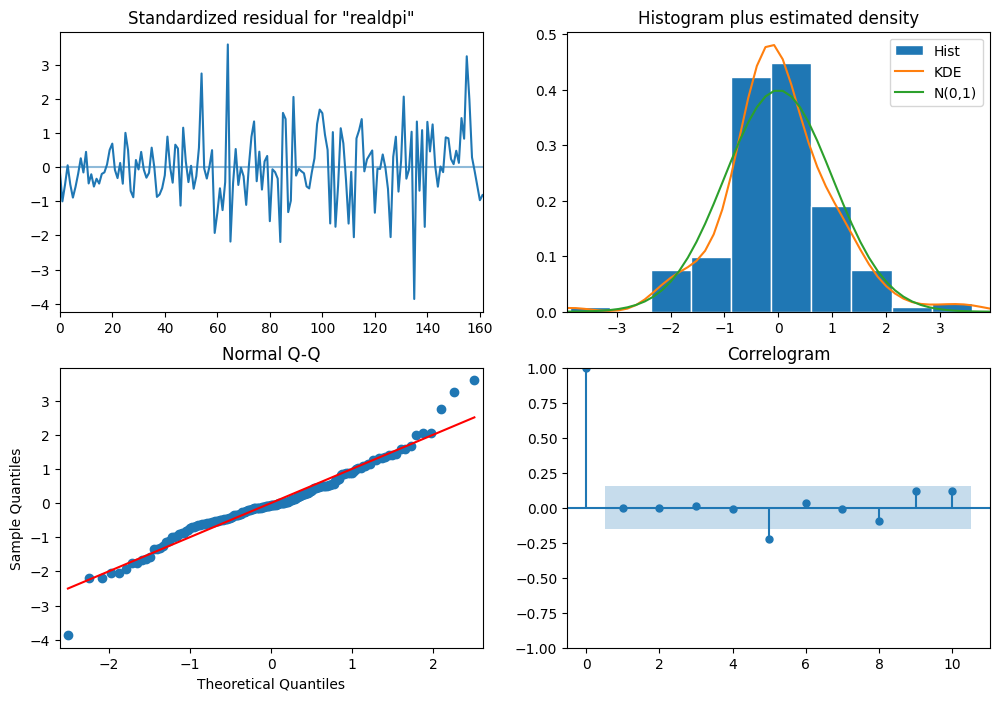

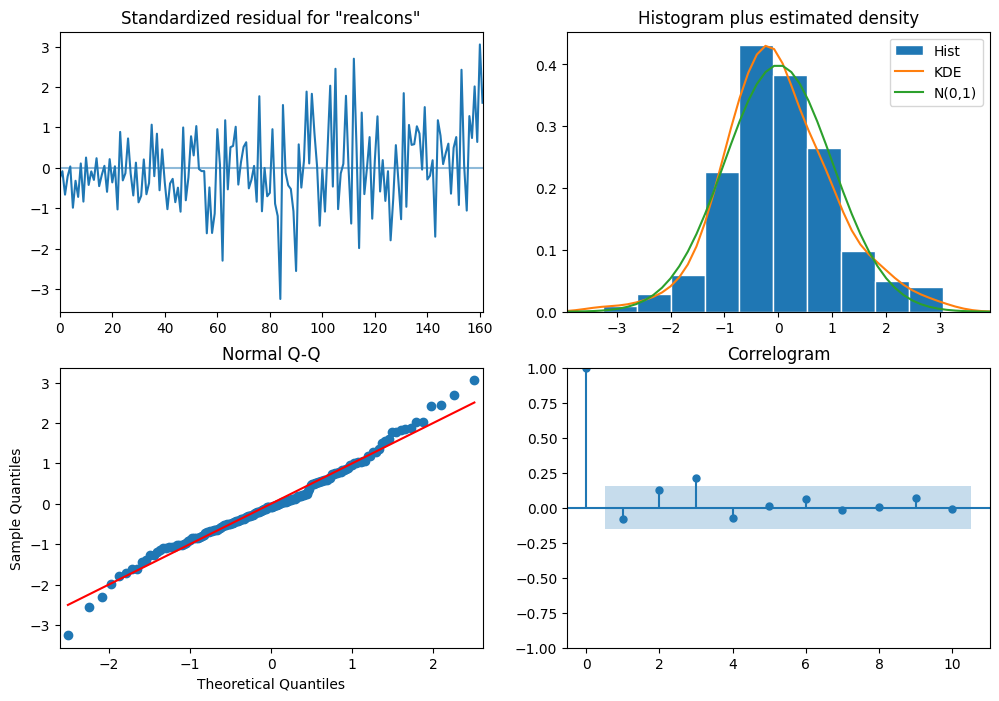

In [34]:
from statsmodels.tsa.statespace.varmax import VARMAXResults

best_model = VARMAX(train, order=(1, 0))
best_model_fit: VARMAXResults = best_model.fit(disp=False)
best_model_fit.plot_diagnostics(figsize=(12,8), variable=0) # realdpi
best_model_fit.plot_diagnostics(figsize=(12,8), variable=1); # realcons

In [11]:
from statsmodels.stats.diagnostic import acorr_ljungbox

def get_varmax_residual_pvalues(residuals: pd.Series):
    lb_df = acorr_ljungbox(residuals, np.arange(1, 11))
    lb_df = (lb_df
             .sort_values(by='lb_pvalue', ascending=True)
             .reset_index(drop=True))
    return lb_df

print('realdpi\n', get_varmax_residual_pvalues(best_model_fit.resid['realdpi']))
print('realcons\n', get_varmax_residual_pvalues(best_model_fit.resid['realcons']))

realdpi
      lb_stat  lb_pvalue
0  10.632427   0.386863
1   4.758906   0.446006
2   8.495749   0.485058
3   4.867810   0.560876
4   5.973548   0.650195
5   4.886061   0.673865
6   0.014555   0.903974
7   0.019954   0.990073
8   0.079422   0.994187
9   0.163507   0.996835
realcons
     lb_stat  lb_pvalue
0  3.410706   0.906008
1  3.622743   0.934445
2  0.002856   0.957383
3  3.668726   0.961057
4  0.511864   0.972336
5  0.841070   0.974340
6  1.640996   0.977023
7  1.168726   0.978401
8  0.011747   0.994144
9  0.012592   0.999626


In [14]:
from typing import Literal
from statsmodels.tsa.statespace.varmax import VARMAXResults
from statsmodels.tsa.statespace.mlemodel import PredictionResults

def rolling_forecast(
    data: pd.DataFrame,
    train_len: int,
    horizon: int,
    window: int,
    method: Literal['VARMAX', 'last'],
) -> tuple[np.ndarray, np.ndarray]: # (realdpi, realcons)
    assert len(data) == train_len + horizon
    realdpi_pred = np.empty(horizon)
    realcons_pred = np.empty(horizon)
    if method == 'VARMAX':
        for i in range(0, horizon, window):
            model = VARMAX(data[:train_len+i], order=(4, 1))
            res: VARMAXResults = model.fit(disp=False)
            predictions: PredictionResults = res.get_prediction(0, train_len+i+window-1)
            oos_pred: pd.DataFrame = predictions.predicted_mean.iloc[-window:]
            oos_pred_realdpi = oos_pred['realdpi'].values
            oos_pred_realcons = oos_pred['realcons'].values
            realdpi_pred[i:i+window] = oos_pred_realdpi
            realcons_pred[i:i+window] = oos_pred_realcons
        return realdpi_pred, realcons_pred
    elif method == 'last':
        for i in range(0, horizon, window):
            last = data[:train_len+i].iloc[-1]
            realdpi_pred[i:i+window] = last['realdpi']
            realcons_pred[i:i+window] = last['realcons']
        return realdpi_pred, realcons_pred

In [13]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4

In [15]:
realdpi_pred_VARMA, realcons_pred_VARMA = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VARMAX')

c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-pac

In [19]:
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN+1, HORIZON, WINDOW, 'last')

In [20]:
forecast = endog[163:]
forecast = forecast.assign(realdpi_pred_VARMA=(endog.iloc[162]['realdpi'] + 
                                             np.cumsum(realdpi_pred_VARMA)),
                           realcons_pred_VARMA=(endog.iloc[162]['realcons'] + 
                                              np.cumsum(realcons_pred_VARMA)),
                           realdpi_pred_last=realdpi_pred_last,
                           realcons_pred_last=realcons_pred_last)
forecast.head(10)

,realdpi,realcons,realdpi_pred_VARMA,realcons_pred_VARMA,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7823.251596,7360.600698,7765.9,7286.4
164,8053.4,7501.3,7892.590097,7439.886927,7765.9,7286.4
165,8135.9,7571.8,7962.980744,7507.901848,7765.9,7286.4
166,8222.3,7645.9,8026.043409,7570.435936,7765.9,7286.4
167,8234.6,7713.5,8089.971591,7647.549811,8222.3,7645.9
168,8296.5,7744.3,8142.805529,7715.452021,8222.3,7645.9
169,8273.7,7773.5,8192.254998,7782.119433,8222.3,7645.9
170,8484.5,7807.7,8244.413014,7848.126851,8222.3,7645.9
171,8385.5,7930.0,8248.128188,7901.762510,8484.5,7807.7
172,8611.6,7957.3,8303.003724,7932.043205,8484.5,7807.7


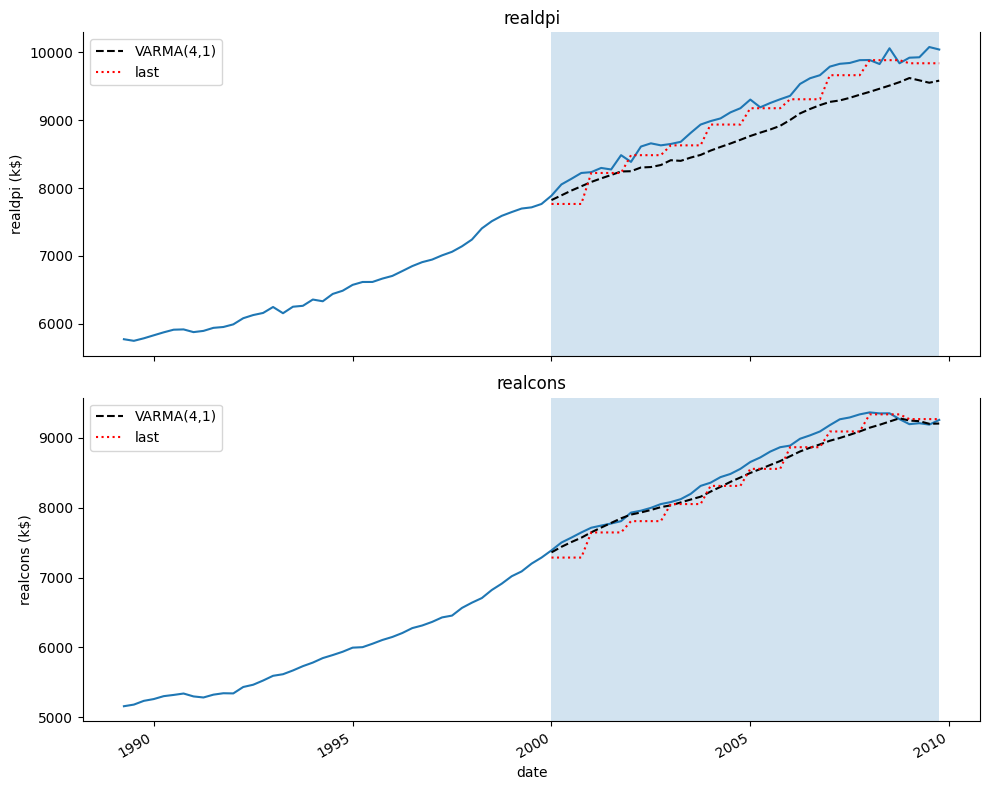

In [21]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

xx = macro_econ_data['year'] + .25 * macro_econ_data['quarter']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1: Axes; ax2: Axes

START = 120

ax1.plot(xx[START:], macro_econ_data['realdpi'][START:])
ax1.set_xlabel('date')
ax1.set_ylabel('realdpi (k$)')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)
ax1.axvspan(xx[163], xx.iloc[-1], alpha=.2)
ax1.plot(xx[163:], forecast['realdpi_pred_VARMA'], 'k--', label='VARMA(4,1)')
ax1.plot(xx[163:], forecast['realdpi_pred_last'], 'r:', label='last')
ax1.legend(loc=2)


ax2.plot(xx[START:], macro_econ_data['realcons'][START:])
ax2.set_xlabel('date')
ax2.set_ylabel('realcons (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)
ax2.axvspan(xx[163], xx.iloc[-1], alpha=.2)
ax2.plot(xx[163:], forecast['realcons_pred_VARMA'], 'k--', label='VARMA(4,1)')
ax2.plot(xx[163:], forecast['realcons_pred_last'], 'r:', label='last')
ax2.legend(loc=2)

fig.autofmt_xdate()
fig.tight_layout()

In [22]:
from sklearn.metrics import mean_absolute_percentage_error

mape_last = mean_absolute_percentage_error(forecast['realdpi'], forecast['realdpi_pred_last'])
mape_VARMA = mean_absolute_percentage_error(forecast['realdpi'], forecast['realdpi_pred_VARMA'])

print('realdpi')
print(f'MAPE of last: {100*mape_last:.2f}%')
print(f'MAPE of VARMA: {100*mape_VARMA:.2f}%')

mape_last = mean_absolute_percentage_error(forecast['realcons'], forecast['realcons_pred_last'])
mape_VARMA = mean_absolute_percentage_error(forecast['realcons'], forecast['realcons_pred_VARMA'])

print('realcons')
print(f'MAPE of last: {100*mape_last:.2f}%')
print(f'MAPE of VARMA: {100*mape_VARMA:.2f}%')

realdpi
MAPE of last: 1.71%
MAPE of VARMA: 3.80%
realcons
MAPE of last: 1.68%
MAPE of VARMA: 1.25%
